# Continuous Control for Reacher Unity Agent

---

In this notebook, we train the Reacher Unity ML-Agent for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

Please double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
# import necessary functions and network classes
from ACnets import Policy, Critic
from Training import *

using device:  cpu


Make sure that you have downloaded the correct version of the Unity environment and change the `file_name` parameter to match its location.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

In [2]:
os_file = 'Reacher_Windows_x86_64/Reacher.exe'
# os_file = 'Reacher_Linux/Reacher.x86_64' # 'Reacher_Linux_NoVis/Reacher.x86_64'
env = UnityEnvironment(file_name=os_file)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
# size of each action
action_size = brain.vector_action_space_size
# size of the state space 
states = env_info.vector_observations
state_size = states.shape[1]

print('Number of agents:', num_agents)
print('Size of each action:', action_size)
print('vector_observations have shape: ',states.shape)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('States is type: ',type(states))

Number of agents: 20
Size of each action: 4
vector_observations have shape:  (20, 33)
There are 20 agents. Each observes a state with length: 33
States is type:  <class 'numpy.ndarray'>


In [5]:
# initialize actor and critic 
policy = Policy(state_size, action_size).to(device)
critic = Critic(state_size).to(device)

Actor has input size 33  hidden layer 1 size:  256  hidden layer 2 size:  256  action_size 4
Critic has input size 33  hidden layer 1 size:  256  hidden layer 2 size:  256


In [6]:
States, LogPs, Actions, Rewards, Vs, scores = get_samples(env, policy, critic)
print(np.mean(scores))
print(States.shape, LogPs.shape, Actions.shape, Rewards.shape, Vs.shape)

0.26849999399855734
(1001, 20, 33) (1001, 20) (1001, 20, 4) (1001, 20) (1001, 20)


1.8417110312730074 -0.2274177372455597
1.0100001 0.0
(1001, 20) (1001, 20)


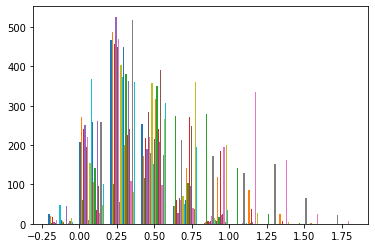

In [7]:
discount, lmda = 1,1
Adv = advantage_estimate(Rewards, discount, Vs, lmda)
print(Adv.max(),Adv.min())
Ret = norm_returns(Rewards, discount)
print(Ret.max(),Ret.min())
print(Adv.shape,Ret.shape)
plt.figure()
plt.hist(Adv)
plt.show()

In [8]:
States = torch.tensor(States, dtype=torch.float, device=device).view(-1,States.shape[-1])
Adv = torch.tensor(Adv, dtype=torch.float, device=device).view(-1)
Actions = torch.tensor(Actions, dtype=torch.float, device=device).view(-1,Actions.shape[-1])
LogPs = torch.tensor(LogPs, dtype=torch.float, device=device).view(-1)

loss = PPO(policy, States, LogPs, Actions, Adv, epsilon=0.2, debug=True)

torch.Size([20020, 33]) torch.Size([20020, 4])
tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
       grad_fn=<ExpBackward>)
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         0.0000e+00, -4.7684e-07], grad_fn=<SubBackward0>)


In [9]:
inputsize, action_size = state_size, action_size
policy = Policy(inputsize, action_size).to(device)
critic = Critic(inputsize).to(device)

Actor has input size 33  hidden layer 1 size:  256  hidden layer 2 size:  256  action_size 4
Critic has input size 33  hidden layer 1 size:  256  hidden layer 2 size:  256


In [10]:
mean_rewards, ploss, closs = train(env, policy, critic, 25)
# I need to stabilize learning. Possible ways:
#  1. decrease noise_decay (tested 0.98 but maybe a bit smaller) -> not working
#  2. decrease epsilon to 0.1 -> not working
#  3. implement noise learning -> works!
#--- clipping gradient? not necessary, although performance seems to increase a bit



Episode: 5, score (averaged over agents): 0.827000
Policy loss: -0.040288083255290985 | Critic loss: 9.248282003682107e-05


Episode: 10, score (averaged over agents): 1.982500
Policy loss: -0.06027517840266228 | Critic loss: 0.0007343698525801301


Episode: 15, score (averaged over agents): 2.571000
Policy loss: -0.06657105684280396 | Critic loss: 0.0007229623734019697


Episode: 20, score (averaged over agents): 3.432500
Policy loss: -0.07290889322757721 | Critic loss: 0.0018987191142514348


Episode: 25, score (averaged over agents): 4.345500
Policy loss: -0.08047889918088913 | Critic loss: 0.0023101973347365856


Text(0.5, 1.0, 'Critic loss')

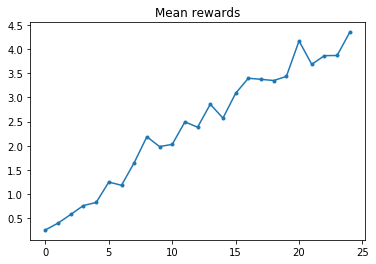

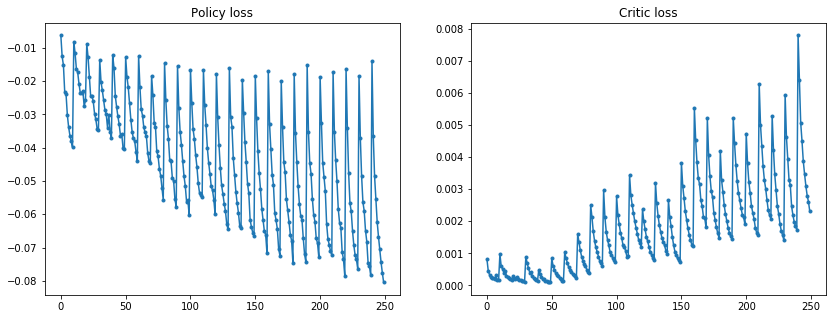

In [11]:
plt.figure()
plt.plot(mean_rewards,'.-')
plt.title("Mean rewards")
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(ploss,'.-')
plt.title("Policy loss")
plt.subplot(122)
plt.plot(closs,'.-')
plt.title("Critic loss")
#[:100]

In [12]:
env.close()